## 导入依赖库

In [1]:
import tensorflow as tf
# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle


from libs.configs import cfgs


print("Tensorflow version " + tf.__version__)

++--++--++--++--++--++--++--++--++--++--++--++--++--++--++--++--++--++--++--++--
/home/alex/python_code/Image-Caption
Tensorflow version 2.2.0


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

In [2]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))
# print(tf.test.is_gpu_available())

## Download and prepare the MS-COCO dataset
You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.


In [3]:
# Download caption annotation files

# annotation_folder = '/annotations/'
# if not os.path.exists(os.path.abspath('.') + annotation_folder):
#   annotation_zip = tf.keras.utils.get_file('captions.zip',
#                                           cache_subdir=os.path.abspath('.'),
#                                           origin = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip',
#                                           extract = True)
#   os.remove(annotation_zip)

  
# image_folder = '/train2017/'
# if not os.path.exists(os.path.abspath('.') + image_folder):
#   image_zip = tf.keras.utils.get_file('train2017.zip',
#                                       cache_subdir=os.path.abspath('.'),
#                                       origin = 'http://images.cocodataset.org/zips/train2017.zip',
#                                       extract = True)
#   os.remove(image_zip)
# else:
#   PATH = os.path.abspath('.') + image_folder


In [4]:
# !wget 
# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# !http://images.cocodataset.org/zips/train2017.zip'
# !upzip captions.zip -d ./
# !upzip train2017.zip -d ./
# !cp captions.zip /content/drive/My\ Drive/dataset/coco_2017/
# !cp train2017.zip /content/drive/My\ Drive/dataset/coco_2017/


## Download coco


In [5]:
# !cp captions.zip /contents/drive/My \ Drive\dataset\coco_2017
# !cp train2017.zip /contents/drive/My \ Drive\dataset\coco_2017

# ! unzip -d ./annotations test.zip
# ! unzip -d ./images train2017.zip

In [6]:
# annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2017.json'
# image_path = os.path.dirname(image_zip) + '/train2017/'
image_dir = os.path.join(cfgs.DATASET_PATH, 'train2017/')
annotation_file = os.path.join(cfgs.DATASET_PATH, 'annotations', 'captions_train2017.json')
print(annotation_file)
print(image_dir)

/media/alex/AC6A2BDB6A2BA0D6/alex_dataset/COCO_2017/annotations/captions_train2017.json
/media/alex/AC6A2BDB6A2BA0D6/alex_dataset/COCO_2017/train2017/


## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [7]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)
print(len(annotations['annotations']))

591753


In [8]:
# Group all captions together having the same image ID.
# note: a image have multi caption
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  
  image_path = image_dir + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(val['caption'])
print(len(image_path_to_caption))

118287


## Get samples

In [9]:
random.seed(0)
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)
# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will 
# lead to 40,000 examples.
train_image_samples = image_paths[:8000]
print("train image samples {0}".format(len(train_image_samples)))

train image samples 8000


In [10]:
train_captions = []
img_name_vector = []

for image_path in train_image_samples:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(['<start> ' + caption + ' <end>' for caption in caption_list])
  img_name_vector.extend([image_path] * len(caption_list))
print("train images: ", len(img_name_vector))
print("train captions: ", len(train_captions))

train images:  40028
train captions:  40028


<start> Little girl brushing her teeth in a small bathroom. <end>


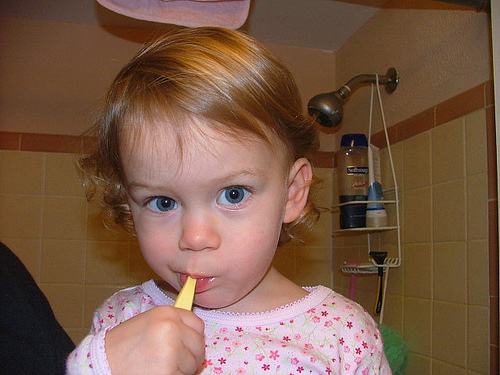

In [11]:
# show samples
print(train_captions[0])
Image.open(img_name_vector[0])

In [12]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [13]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## Caching the features extracted from InceptionV3

In [14]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
    batch_features = image_features_extract_model(img)
    # （batch_size, 8, 8, 2048）=> (batch_size, 64, 2048)
    batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path = p.numpy().decode("utf-8")
        np.save(os.path.join(cfgs.IMAGE_FEATURE_PATH, os.path.basename(path)), bf.numpy())

## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [15]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [16]:
# Choose the top 5000 words from the vocabulary
top_k = 6000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [17]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [18]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [19]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [20]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [21]:
def split_dataset(image_name, sequence, split_ratio):
    img_name_train, img_name_val, cap_train, cap_val = train_test_split(image_name,
                                                                        sequence,
                                                                        test_size=split_ratio,
                                                                        shuffle=True)
    return img_name_train, img_name_val, cap_train, cap_val

In [22]:
img_name_train, img_name_val, cap_train, cap_val = split_dataset(img_name_vector, cap_vector, 0.2)

print(len(img_name_train), len(img_name_val), len(cap_train), len(cap_val))
print(img_name_train[0], cap_train[0])

32022 8006 32022 8006
/media/alex/AC6A2BDB6A2BA0D6/alex_dataset/COCO_2017/train2017/000000143822.jpg [   3    2  259  515   95    5    2  310   24    9    2  259 3498   10
  527    4    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0]


## Create a tf.data dataset for training

In [23]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 512
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [24]:
def load_feature(img_name, img_caption):
    feature_path = os.path.join(cfgs.IMAGE_FEATURE_PATH, os.path.basename(img_name.decode('utf-8')) + '.npy')
    img_feature = np.load(feature_path)

    return img_feature, img_caption

In [25]:
def dataset_batch(img_name, img_caption, batch_size, buffer_size=1000):
    """

    :param img_name:
    :param img_caption:
    :param batch_size:
    :param buffer_size:
    :param epoch:
    :return:
    """

    dataset = tf.data.Dataset.from_tensor_slices((img_name, img_caption))
    # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_feature,
                                                                 inp=[item1, item2],
                                                                 Tout=[tf.float32, tf.int32]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Shuffle and batch
    dataset = dataset.shuffle(buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [26]:
dataset = dataset_batch(img_name_train, cap_train, batch_size=BATCH_SIZE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [27]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units=units)
        self.W2 = tf.keras.layers.Dense(units=units)
        self.V = tf.keras.layers.Dense(units=1)


    def __call__(self, feature, hidden):
        """

        :param feature: (batch_size, 64, embedding_dim)
        :param hidden: (batch_size, hidden_size)
        :return:
        """
        # (batch_size, 1,  hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, axis=1)

        # attention_hidden_layer => (batch_size, 64, num_units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(feature) + 
                                             self.W2(hidden_with_time_axis)))

        # scores => (batch_size, 64, 1)
        scores = self.V(attention_hidden_layer)

        # attention_weights => (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(scores, axis=1)

        # context_vector => (batch_size, embedding_dim)
        context_vector = attention_weights * feature  #  (batch_size, 64, embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) #  (batch_size, embedding_dim)

        return context_vector, attention_weights

In [28]:
class CNNEencoder(tf.keras.Model):
    """

    """
    def __init__(self, embedding_dim):
        super(CNNEencoder, self).__init__()
        self.fc = tf.keras.layers.Dense(units=embedding_dim)

    def __call__(self, x):
        """

        :param x: (batch_size, 64, 2048)
        :return: (batch_size, 64, embedding_dim)
        """
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [29]:
class RNNDecoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):

        super(RNNDecoder, self).__init__()
        self.units = units
        self.vocab_size = vocab_size
        self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(self.vocab_size)

        self.attention = BahdanauAttention(units=self.units)

    def __call__(self, x, feature, hidden):
        """

        :param x: (batch_size, 1)
        :param feature: (batch_size, 64, embedding_dim)
        :param hidden:  (batch_size, hidden_size)
        :return:
        """
        # context_vector => (batch_size, embedding_dim(hidden_size))
        # attention_weights => (batch_size, 64, 1)
        context_vector, attention_weights = self.attention(feature, hidden)

        # embedding layer x => (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x after concat => (batch_size, 1,  embedding_dim + embedding_dim(hidden_size))
        x = tf.concat([tf.expand_dims(context_vector, axis=1), x], axis=-1)

        # passing the concatenated vector to gru
        # outputs => (batch_size, 1, num_units)
        # states => (batch_size, num_units)
        outputs, states = self.gru(x)

        # x => (batch_size, 1, units)
        x = self.fc1(x)

        # x => (batch_size, num_units)
        x = tf.reshape(x, (-1, x.shape[-1]))

        # x => (batch_size, vocab_size)
        x = self.fc2(x)

        return x, states, attention_weights


    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [30]:
encoder = CNNEencoder(embedding_dim)
decoder = RNNDecoder(embedding_dim, units, vocab_size)

## Optimizer strategy

In [31]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [32]:
checkpoint_path = cfgs.TRAINED_CKPT
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [33]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training logs

In [34]:
summary_path = cfgs.SUMMARY_PATH
summary_writer = tf.summary.create_file_writer(summary_path)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [35]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [36]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [37]:
EPOCHS = 40

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    with summary_writer.as_default():
      tf.summary.scalar('loss', (total_loss / num_steps), step=epoch)

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9687
Epoch 1 Batch 100 Loss 1.0382
Epoch 1 Batch 200 Loss 0.8897
Epoch 1 Batch 300 Loss 0.7512
Epoch 1 Batch 400 Loss 0.7948
Epoch 1 Loss 0.923245
Time taken for 1 epoch 88.17611455917358 sec

Epoch 2 Batch 0 Loss 0.7337
Epoch 2 Batch 100 Loss 0.7879
Epoch 2 Batch 200 Loss 0.7301
Epoch 2 Batch 300 Loss 0.7014
Epoch 2 Batch 400 Loss 0.7329
Epoch 2 Loss 0.736541
Time taken for 1 epoch 62.44326567649841 sec

Epoch 3 Batch 0 Loss 0.7084
Epoch 3 Batch 100 Loss 0.6609
Epoch 3 Batch 200 Loss 0.6561
Epoch 3 Batch 300 Loss 0.6486
Epoch 3 Batch 400 Loss 0.6355
Epoch 3 Loss 0.671116
Time taken for 1 epoch 62.63709473609924 sec

Epoch 4 Batch 0 Loss 0.6267
Epoch 4 Batch 100 Loss 0.6538
Epoch 4 Batch 200 Loss 0.6610
Epoch 4 Batch 300 Loss 0.6039
Epoch 4 Batch 400 Loss 0.5631
Epoch 4 Loss 0.625121
Time taken for 1 epoch 62.88123393058777 sec

Epoch 5 Batch 0 Loss 0.6002
Epoch 5 Batch 100 Loss 0.6109
Epoch 5 Batch 200 Loss 0.6013
Epoch 5 Batch 300 Loss 0.5714
Epoch 5 Batch 400 

Epoch 38 Batch 100 Loss 0.2685
Epoch 38 Batch 200 Loss 0.2966
Epoch 38 Batch 300 Loss 0.3003
Epoch 38 Batch 400 Loss 0.2688
Epoch 38 Loss 0.278617
Time taken for 1 epoch 63.475571632385254 sec

Epoch 39 Batch 0 Loss 0.3178
Epoch 39 Batch 100 Loss 0.2885
Epoch 39 Batch 200 Loss 0.2895
Epoch 39 Batch 300 Loss 0.2784
Epoch 39 Batch 400 Loss 0.2415
Epoch 39 Loss 0.275583
Time taken for 1 epoch 63.53841543197632 sec

Epoch 40 Batch 0 Loss 0.2998
Epoch 40 Batch 100 Loss 0.2647
Epoch 40 Batch 200 Loss 0.2845
Epoch 40 Batch 300 Loss 0.2832
Epoch 40 Batch 400 Loss 0.2695
Epoch 40 Loss 0.272273
Time taken for 1 epoch 63.52760601043701 sec



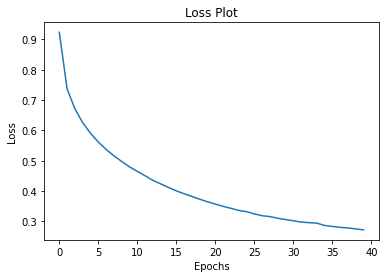

In [38]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [39]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [40]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a tall brick clock tower towering over a city <end>
Prediction Caption: a very tall antique tower with brown clock tower on a cloudy sky <end>


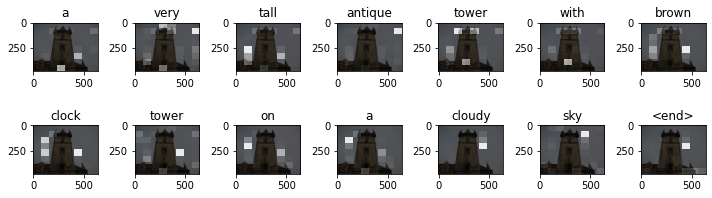

In [42]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Try it on your own images

Prediction Caption: a man riding a wave in a wet suit riding a black surfboard <end>


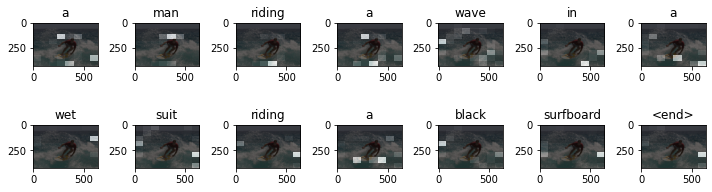

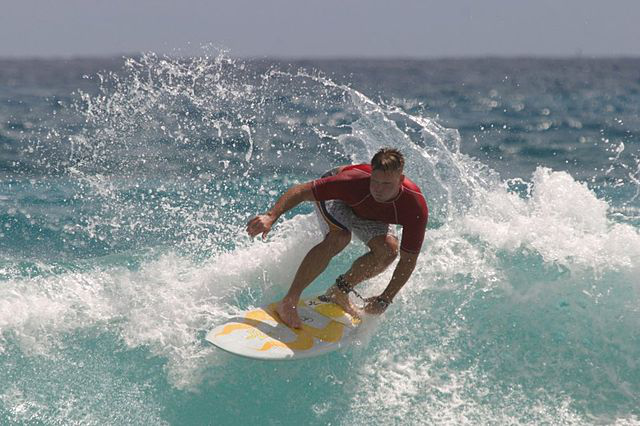

In [43]:
# image_url = 'https://tensorflow.org/images/surf.jpg'
# image_extension = image_url[-4:]
# image_path = tf.keras.utils.get_file('image'+image_extension,
#                                      origin=image_url)
image_path = os.path.abspath(os.path.join('./tools/demo', 'surf.jpg'))

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)